# Classification of movements using Interpolation based on Restimulus

**Basic Imports and Helper Functions**

In [1]:
# Imports
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.io import loadmat

In [2]:
def load_data_DB1(subject,exercise):
    data = loadmat(f'../Dataset/DB1/s{subject}/S{subject}_A1_E{exercise}.mat')
    return data

In [3]:
def get_start_indexes(data,movement,target):
    start_indexes=[]
    for idx,move in enumerate(data[target]):
        if move[0] == movement and data[target][idx-1][0] == 0:
            start_indexes.append(idx)
        if len(start_indexes) == 10:
            break
    return start_indexes

In [4]:
def get_movement_df(data,movement,target):
    '''
    Returns the repetitions of a movement based on fixed length of repetition.
    if target is stimulus then each rep takes 5 seconds but if target is restimulus then each rep takes 2 seconds
    '''
    start_indexes = get_start_indexes(data,movement,target)
    df= pd.DataFrame()
    step = 500 if target == 'stimulus' else 200
    for i in start_indexes:
        new_row = data['emg'][i:i+step].flatten()
        df = df.append(pd.Series(new_row),ignore_index=True)
    target_movement = np.full((10,1),movement,dtype=int)
    df['target_movement'] = target_movement
    return df

In [5]:
def get_full_repetitions(data, movement):
    '''
    Returns a dataframe with the 10 repetitions of a movement  based on restimulus.
    The returned dataframe considers the varying length of each repetition.
    '''
    df = pd.DataFrame()
    restimulus_indices = get_start_indexes(data=data, movement=movement, target="restimulus")
    for i in restimulus_indices:
        j = i
        while data["restimulus"][j] == movement:
            j+=1
        repetition_df = pd.DataFrame(data["emg"][i:j].flatten().reshape(1,len(data["emg"][i:j].flatten())))
        repetition_df["target"] = movement
        df = df.append(repetition_df, ignore_index=True)

    col_names = list(range(0,df.shape[1] - 1))
    col_names.append("target")
    df = df.reindex(columns=col_names)
    return df

In [6]:
from scipy import interpolate
import math

def interpolate_dataframe___(df):
    '''
    Takes a dataframe with NaN and returns an interpolated version of the dataframe with no NaNs.
    '''
    data = df.drop("target", axis=1)
    target_col = df["target"]
    
    max_row_length = data.shape[1]
    max_range = list(range(0, max_row_length))
    print("Before preparing for interpolation")   
    for idx,row in data.iterrows():
        current_row_length = len(row.dropna())
        current_range = list(range(0, current_row_length))
        new_row = pd.Series(index=max_range, dtype='float64')
        
        for i in current_range:
            j = math.ceil(i * max_row_length / current_row_length)
            new_row.loc[j] = row.iloc[i]
            
        print(f"After preparing row {idx} for interpolation")   
        new_row.interpolate(method="linear",inplace=True)
        data.iloc[idx] = new_row
    data["target"] = target_col
    return data

In [7]:
from scipy import interpolate
import math

def interpolate_single_row(row):
    max_length = len(row)
    current_row_length = len(row.dropna())
    current_range = list(range(0, current_row_length))
    new_row = pd.Series(index=list(range(0,max_length)), dtype='float64')

    for i in current_range:
        j = math.ceil(i * max_length / current_row_length)
        new_row.loc[j] = row.iloc[i]

    new_row.interpolate(method="linear",inplace=True)
    return new_row

def interpolate_dataframe(df):
    '''
    Takes a dataframe with NaN and returns an interpolated version of the dataframe with no NaNs.
    '''
    data = df.drop("target", axis=1)
    interpolated_data = pd.DataFrame()
    target_col = df["target"]
    
    max_row_length = data.shape[1]
    max_range = list(range(0, max_row_length))
    
    interpolated_data = interpolated_data.append(data.apply(lambda row: interpolate_single_row(row), axis=1), ignore_index=True)
    interpolated_data["target"] = target_col
    return interpolated_data

In [8]:
from scipy import interpolate
import math

def interpolate_dataframe_with_length(df, max_length):
    '''
    Takes a dataframe and a desired length for data (ignoring target column) with NaN and returns an interpolated version of the dataframe with no NaNs.
    '''
    data = df.drop("target", axis=1)
    target_col = df["target"]
    
    max_row_length = max_length
    max_range = list(range(0, max_row_length))
    
    # Creating datafram to hold new data with new length
    new_data = pd.DataFrame(columns=max_range)

    for idx,row in data.iterrows():
        current_row_length = len(row.dropna())
        current_range = list(range(0, current_row_length))
        new_row = pd.Series(index=max_range, dtype='float64')
        for i in current_range:
            j = math.ceil(i * max_row_length / current_row_length)
            new_row.loc[j] = row.loc[i]
        new_row.interpolate(method="linear",inplace=True)
        new_data = new_data.append(new_row, ignore_index=True)
    new_data["target"] = target_col
    return new_data

**Models Used**

In [9]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

models = {"LogisticRegression": LogisticRegression(max_iter=10000, n_jobs=-1),
         "SVC": SVC(kernel='rbf'),
         "RandomForestClassifier": RandomForestClassifier(n_estimators=100, n_jobs=-1),
         "KNN": KNeighborsClassifier(n_neighbors=5, n_jobs=-1)}

## 1. Classification Per Exercise  per subject

**Exercise 1**

In [14]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.decomposition import PCA

np.random.seed(42)

test_accuracy_models_ex1 = {}

# Initialize lists for each model .. Each list should contain 27 values(number of subjects)
for label, model in models.items():
    test_accuracy_models_ex1[label] = []


ex1_movements = list(range(1,13))

# Iterate over 27 subjects of DB1 and trying to classify exercise 1 
for sub in list(range(1,28)):

    # Load the data 
    data = load_data_DB1(subject=sub, exercise=1)

    # Iterate over all movements and add them into a df
    df = pd.DataFrame()
    for m in ex1_movements:
        df = df.append(get_full_repetitions(data=data, movement=m),ignore_index=True)

    # Interpolate the dataframe to fill NaN values using linear interpolation
    df_interpolated = interpolate_dataframe(df)

    # Getting X & y
    X = df_interpolated.drop("target", axis=1)
    y = df_interpolated["target"]

#     pca = PCA(n_components=0.95)
#     X_transformed = pca.fit_transform(X)
    
    # Splitting the data once with pca and once without
    X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)
#     X_train_pca, X_test_pca, y_train_pca, y_test_pca = train_test_split(X_transformed, y, stratify=y, test_size=0.2, random_state=42)
    
#     clf = RandomForestClassifier(n_estimators=100)
#     clf_pca = RandomForestClassifier(n_estimators=100)
    
     #Fitting the model
    for label, model in models.items():
        model.fit(X_train, y_train)
        score = round(model.score(X_test, y_test) * 100, 3)
        test_accuracy_models_ex1[label].append(score)
        print(f"Test Accuracy for subject {sub} in exercise 1 using {label} is {score}")
    
    print("-----------------------------------------------------------------------------------")

#     # Scoring the two models
#     score = round(clf.score(X_test, y_test) * 100,2)
#     pca_score = round(clf_pca.score(X_test_pca, y_test_pca) * 100 , 2)
    
#     print(f"Test Accuracy for subject {sub} and exercise 1 using interpolation is {score}")
#     print(f"Test Accuracy for subject {sub} and exercise 1 using interpolation and pca with 95% components is {pca_score}")
#     print("-----------------------------------------------------------------------------------")
    
#     test_acc_inter_subjects_ex1.append(score)
#     test_acc_inter_subjects_ex1_pca.append(pca_score)

# print(f"Average Training Accuracy for all subjects in exercise 1 {np.mean(training_acc_subjects)}")
# print(f"Average Test Accuracy for all subjects in exercise 1 using interpolation {np.mean(test_acc_inter_subjects_ex1)}")
# print(f"Average Test Accuracy for all subjects in exercise 1 using interpolation and 95% PCA {np.mean(test_acc_inter_subjects_ex1_pca)}")


for label, model in models.items():
    print(f"Average Test Accuracy for all subjects in exercise 1 using {label} {np.mean(test_accuracy_models_ex1[label])}")


Test Accuracy for subject 1 in exercise 1 using LogisticRegression is 25.0
Test Accuracy for subject 1 in exercise 1 using SVC is 33.333
Test Accuracy for subject 1 in exercise 1 using RandomForestClassifier is 25.0
Test Accuracy for subject 1 in exercise 1 using KNN is 25.0
-----------------------------------------------------------------------------------
Test Accuracy for subject 2 in exercise 1 using LogisticRegression is 33.333
Test Accuracy for subject 2 in exercise 1 using SVC is 25.0
Test Accuracy for subject 2 in exercise 1 using RandomForestClassifier is 45.833
Test Accuracy for subject 2 in exercise 1 using KNN is 16.667
-----------------------------------------------------------------------------------
Test Accuracy for subject 3 in exercise 1 using LogisticRegression is 8.333
Test Accuracy for subject 3 in exercise 1 using SVC is 29.167
Test Accuracy for subject 3 in exercise 1 using RandomForestClassifier is 37.5
Test Accuracy for subject 3 in exercise 1 using KNN is 16.6

Test Accuracy for subject 24 in exercise 1 using LogisticRegression is 37.5
Test Accuracy for subject 24 in exercise 1 using SVC is 37.5
Test Accuracy for subject 24 in exercise 1 using RandomForestClassifier is 41.667
Test Accuracy for subject 24 in exercise 1 using KNN is 20.833
-----------------------------------------------------------------------------------
Test Accuracy for subject 25 in exercise 1 using LogisticRegression is 37.5
Test Accuracy for subject 25 in exercise 1 using SVC is 50.0
Test Accuracy for subject 25 in exercise 1 using RandomForestClassifier is 37.5
Test Accuracy for subject 25 in exercise 1 using KNN is 20.833
-----------------------------------------------------------------------------------
Test Accuracy for subject 26 in exercise 1 using LogisticRegression is 33.333
Test Accuracy for subject 26 in exercise 1 using SVC is 41.667
Test Accuracy for subject 26 in exercise 1 using RandomForestClassifier is 37.5
Test Accuracy for subject 26 in exercise 1 using 

NameError: name 'test_accuracy_models_ex1' is not defined

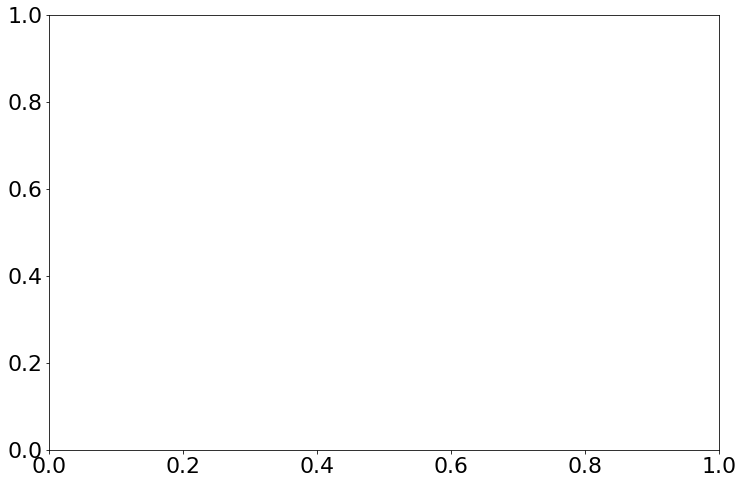

In [22]:
# Plot Average Accuracies for exercise 1
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12,8))
plt.rcParams.update({'font.size': 22})

for label, model in models.items():
    ax.plot(np.arange(1,28), test_accuracy_models_ex1[label])

ax.set_title("Test Scores for 27 subjects for Exercise 1 of interpolated signal using different models")
ax.set_xlabel("Subjects")
ax.set_ylim(0,100)
ax.set_ylabel("Accuracy (%)")
ax.legend(['Logistic Regression','Support Vector Classifier', 'Random Forest', 'K-nearest neigbors' ]);

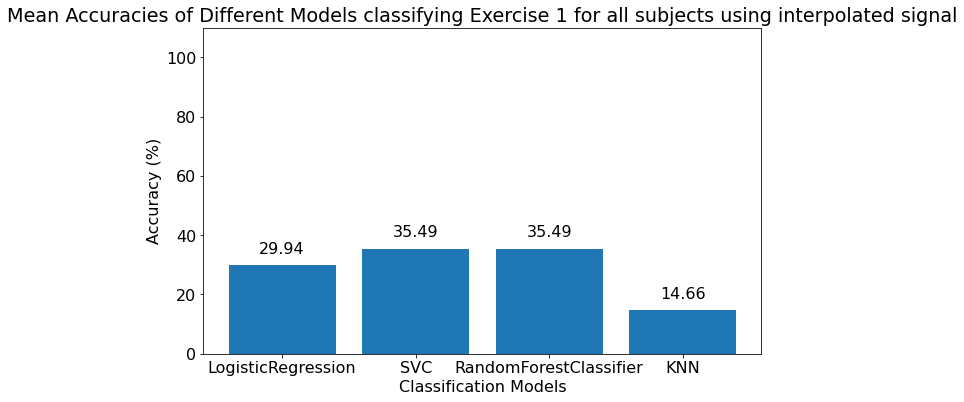

In [16]:
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 16})

mean_accuracies_ex1 = {}

for label, model in models.items():
    mean_accuracies_ex1[label] = np.mean(test_accuracy_models_ex1[label])

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 6))

ax.bar(mean_accuracies_ex1.keys(), mean_accuracies_ex1.values())
ax.set_title("Mean Accuracies of Different Models classifying Exercise 1 for all subjects using interpolated signal")
ax.set_xlabel("Classification Models")
ax.set_ylabel("Accuracy (%)")
ax.set_ylim(0, 110);

rects = ax.patches
for rect, label in zip(rects, mean_accuracies_ex1.values()):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width() / 2, height + 3, round(label, 2 ), ha='center', va='bottom')

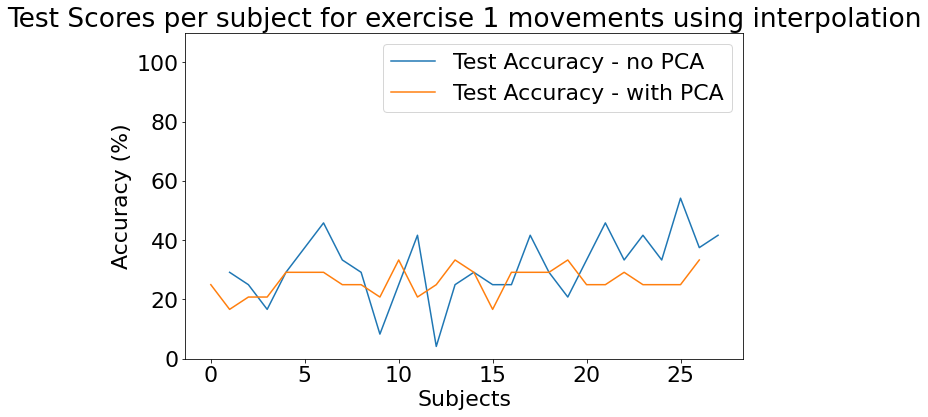

In [128]:
# Plot Average Accuracies for exercise 1
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,6))
plt.rcParams.update({'font.size': 22})

ax.plot(np.arange(1,28), test_acc_inter_subjects_ex1, test_acc_inter_subjects_ex1_pca)
ax.set_title("Test Scores per subject for exercise 1 movements using interpolation")
ax.set_xlabel("Subjects")
ax.set_ylabel("Accuracy (%)")
# ax.set_xticks(np.arange(1,28))
ax.set_ylim(0,110)
ax.legend(["Test Accuracy - no PCA", "Test Accuracy - with PCA"]);

### Classification of exercise 2 movements per subject using RandomForest Classifier and computing the average for all subjects  once with PCA and once without

In [11]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.decomposition import PCA

np.random.seed(42)

test_accuracy_models_ex2 = {}

# Initialize lists for each model .. Each list should contain 27 values(number of subjects)
for label, model in models.items():
    test_accuracy_models_ex2[label] = []


ex2_movements = list(range(1,18))

# Iterate over 27 subjects of DB1 and trying to classify exercise 2
for sub in list(range(1,28)):

    # Load the data 
    data = load_data_DB1(subject=sub, exercise=2)

    # Iterate over all movements and add them into a df
    df = pd.DataFrame()
    for m in ex2_movements:
        df = df.append(get_full_repetitions(data=data, movement=m),ignore_index=True)

    # Interpolate the dataframe to fill NaN values using linear interpolation
    df_interpolated = interpolate_dataframe(df)

    # Getting X & y
    X = df_interpolated.drop("target", axis=1)
    y = df_interpolated["target"]

#     pca = PCA(n_components=0.95)
#     X_transformed = pca.fit_transform(X)
    
    # Splitting the data once with pca and once without
    X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)
#     X_train_pca, X_test_pca, y_train_pca, y_test_pca = train_test_split(X_transformed, y, stratify=y, test_size=0.2, random_state=42)
    
#     clf = RandomForestClassifier(n_estimators=100)
#     clf_pca = RandomForestClassifier(n_estimators=100)
    
     #Fitting the model
    for label, model in models.items():
        model.fit(X_train, y_train)
        score = round(model.score(X_test, y_test) * 100, 3)
        test_accuracy_models_ex2[label].append(score)
        print(f"Test Accuracy for subject {sub} in exercise 2 using {label} is {score}")
    
    print("-----------------------------------------------------------------------------------")

#     # Scoring the two models
#     score = round(clf.score(X_test, y_test) * 100,2)
#     pca_score = round(clf_pca.score(X_test_pca, y_test_pca) * 100 , 2)
    
#     print(f"Test Accuracy for subject {sub} and exercise 1 using interpolation is {score}")
#     print(f"Test Accuracy for subject {sub} and exercise 1 using interpolation and pca with 95% components is {pca_score}")
#     print("-----------------------------------------------------------------------------------")
    
#     test_acc_inter_subjects_ex1.append(score)
#     test_acc_inter_subjects_ex1_pca.append(pca_score)

# print(f"Average Training Accuracy for all subjects in exercise 1 {np.mean(training_acc_subjects)}")
# print(f"Average Test Accuracy for all subjects in exercise 1 using interpolation {np.mean(test_acc_inter_subjects_ex1)}")
# print(f"Average Test Accuracy for all subjects in exercise 1 using interpolation and 95% PCA {np.mean(test_acc_inter_subjects_ex1_pca)}")


for label, model in models.items():
    print(f"Average Test Accuracy for all subjects in exercise 2 using {label} {np.mean(test_accuracy_models_ex2[label])}")


Test Accuracy for subject 1 in exercise 2 using LogisticRegression is 41.176
Test Accuracy for subject 1 in exercise 2 using SVC is 29.412
Test Accuracy for subject 1 in exercise 2 using RandomForestClassifier is 38.235
Test Accuracy for subject 1 in exercise 2 using KNN is 17.647
-----------------------------------------------------------------------------------
Test Accuracy for subject 2 in exercise 2 using LogisticRegression is 29.412
Test Accuracy for subject 2 in exercise 2 using SVC is 29.412
Test Accuracy for subject 2 in exercise 2 using RandomForestClassifier is 32.353
Test Accuracy for subject 2 in exercise 2 using KNN is 11.765
-----------------------------------------------------------------------------------
Test Accuracy for subject 3 in exercise 2 using LogisticRegression is 29.412
Test Accuracy for subject 3 in exercise 2 using SVC is 29.412
Test Accuracy for subject 3 in exercise 2 using RandomForestClassifier is 35.294
Test Accuracy for subject 3 in exercise 2 using 

Test Accuracy for subject 23 in exercise 2 using RandomForestClassifier is 26.471
Test Accuracy for subject 23 in exercise 2 using KNN is 11.765
-----------------------------------------------------------------------------------
Test Accuracy for subject 24 in exercise 2 using LogisticRegression is 47.059
Test Accuracy for subject 24 in exercise 2 using SVC is 47.059
Test Accuracy for subject 24 in exercise 2 using RandomForestClassifier is 44.118
Test Accuracy for subject 24 in exercise 2 using KNN is 14.706
-----------------------------------------------------------------------------------
Test Accuracy for subject 25 in exercise 2 using LogisticRegression is 58.824
Test Accuracy for subject 25 in exercise 2 using SVC is 47.059
Test Accuracy for subject 25 in exercise 2 using RandomForestClassifier is 50.0
Test Accuracy for subject 25 in exercise 2 using KNN is 23.529
-----------------------------------------------------------------------------------
Test Accuracy for subject 26 in e

NameError: name 'test_accuracy_models_ex2' is not defined

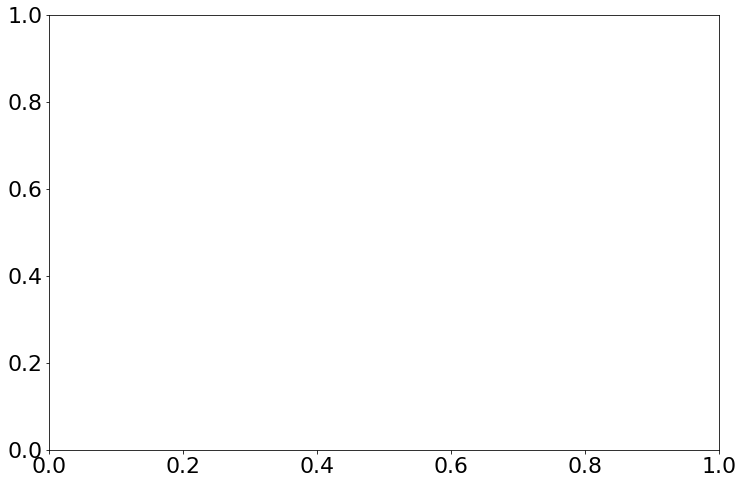

In [21]:
# Plot Average Accuracies for exercise 1
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12,8))
plt.rcParams.update({'font.size': 22})

for label, model in models.items():
    ax.plot(np.arange(1,28), test_accuracy_models_ex2[label])

ax.set_title("Test Scores for 27 subjects for Exercise 2 of interpolated signal using different models")
ax.set_xlabel("Subjects")
ax.set_ylabel("Accuracy (%)")
ax.set_ylim(0,100)
ax.legend(['Logistic Regression','Support Vector Classifier', 'Random Forest', 'K-nearest neigbors' ]);

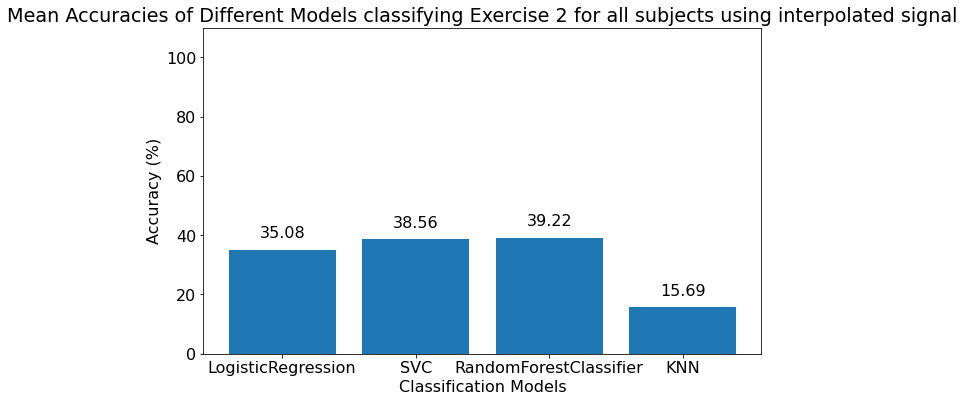

In [13]:
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 16})

mean_accuracies_ex2 = {}

for label, model in models.items():
    mean_accuracies_ex2[label] = np.mean(test_accuracy_models_ex2[label])

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 6))

ax.bar(mean_accuracies_ex2.keys(), mean_accuracies_ex2.values())
ax.set_title("Mean Accuracies of Different Models classifying Exercise 2 for all subjects using interpolated signal")
ax.set_xlabel("Classification Models")
ax.set_ylabel("Accuracy (%)")
ax.set_ylim(0, 110);

rects = ax.patches
for rect, label in zip(rects, mean_accuracies_ex2.values()):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width() / 2, height + 3, round(label, 2 ), ha='center', va='bottom')

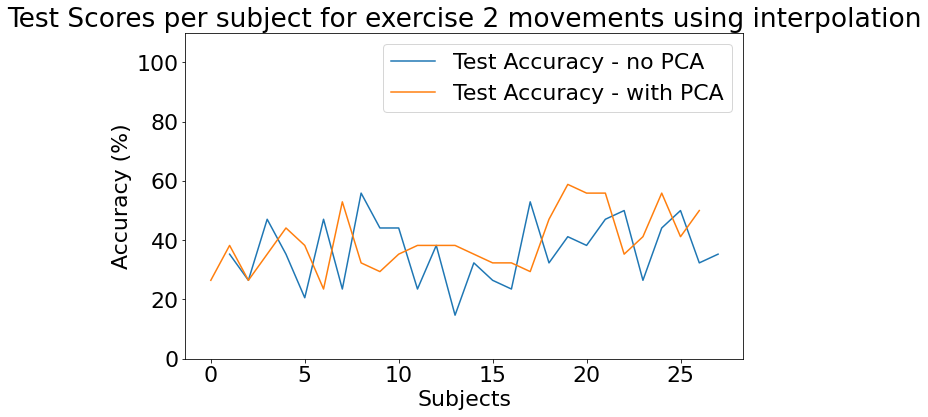

In [130]:
# Plot Average Accuracies for exercise 2
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,6))
plt.rcParams.update({'font.size': 22})

ax.plot(np.arange(1,28), test_acc_inter_subjects_ex2, test_acc_inter_subjects_ex2_pca)
ax.set_title("Test Scores per subject for exercise 2 movements using interpolation")
ax.set_xlabel("Subjects")
ax.set_ylabel("Accuracy (%)")
# ax.set_xticks(np.arange(1,28))
ax.set_ylim(0,110)
ax.legend(["Test Accuracy - no PCA", "Test Accuracy - with PCA"]);

### Classification of exercise 3 movements per subject using RandomForest Classifier and computing the average for all subjects  once with PCA and once without

In [10]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.decomposition import PCA

np.random.seed(42)

test_accuracy_models_ex3 = {}

# Initialize lists for each model .. Each list should contain 27 values(number of subjects)
for label, model in models.items():
    test_accuracy_models_ex3[label] = []


ex3_movements = list(range(1,24))

# Iterate over 27 subjects of DB1 and trying to classify exercise 3
for sub in list(range(1,28)):

    # Load the data 
    data = load_data_DB1(subject=sub, exercise=3)

    # Iterate over all movements and add them into a df
    df = pd.DataFrame()
    for m in ex3_movements:
        df = df.append(get_full_repetitions(data=data, movement=m),ignore_index=True)

    # Interpolate the dataframe to fill NaN values using linear interpolation
    df_interpolated = interpolate_dataframe(df)

    # Getting X & y
    X = df_interpolated.drop("target", axis=1)
    y = df_interpolated["target"]

#     pca = PCA(n_components=0.95)
#     X_transformed = pca.fit_transform(X)
    
    # Splitting the data once with pca and once without
    X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)
#     X_train_pca, X_test_pca, y_train_pca, y_test_pca = train_test_split(X_transformed, y, stratify=y, test_size=0.2, random_state=42)
    
#     clf = RandomForestClassifier(n_estimators=100)
#     clf_pca = RandomForestClassifier(n_estimators=100)
    
     #Fitting the model
    for label, model in models.items():
        model.fit(X_train, y_train)
        score = round(model.score(X_test, y_test) * 100, 3)
        test_accuracy_models_ex3[label].append(score)
        print(f"Test Accuracy for subject {sub} in exercise 3 using {label} is {score}")
    
    print("-----------------------------------------------------------------------------------")

#     # Scoring the two models
#     score = round(clf.score(X_test, y_test) * 100,2)
#     pca_score = round(clf_pca.score(X_test_pca, y_test_pca) * 100 , 2)
    
#     print(f"Test Accuracy for subject {sub} and exercise 1 using interpolation is {score}")
#     print(f"Test Accuracy for subject {sub} and exercise 1 using interpolation and pca with 95% components is {pca_score}")
#     print("-----------------------------------------------------------------------------------")
    
#     test_acc_inter_subjects_ex1.append(score)
#     test_acc_inter_subjects_ex1_pca.append(pca_score)

# print(f"Average Training Accuracy for all subjects in exercise 1 {np.mean(training_acc_subjects)}")
# print(f"Average Test Accuracy for all subjects in exercise 1 using interpolation {np.mean(test_acc_inter_subjects_ex1)}")
# print(f"Average Test Accuracy for all subjects in exercise 1 using interpolation and 95% PCA {np.mean(test_acc_inter_subjects_ex1_pca)}")


for label, model in models.items():
    print(f"Average Test Accuracy for all subjects in exercise 3 using {label} {np.mean(test_accuracy_models_ex3[label])}")


Test Accuracy for subject 1 in exercise 3 using LogisticRegression is 23.913
Test Accuracy for subject 1 in exercise 3 using SVC is 39.13
Test Accuracy for subject 1 in exercise 3 using RandomForestClassifier is 41.304
Test Accuracy for subject 1 in exercise 3 using KNN is 2.174
-----------------------------------------------------------------------------------
Test Accuracy for subject 2 in exercise 3 using LogisticRegression is 23.913
Test Accuracy for subject 2 in exercise 3 using SVC is 32.609
Test Accuracy for subject 2 in exercise 3 using RandomForestClassifier is 19.565
Test Accuracy for subject 2 in exercise 3 using KNN is 13.043
-----------------------------------------------------------------------------------
Test Accuracy for subject 3 in exercise 3 using LogisticRegression is 26.087
Test Accuracy for subject 3 in exercise 3 using SVC is 21.739
Test Accuracy for subject 3 in exercise 3 using RandomForestClassifier is 21.739
Test Accuracy for subject 3 in exercise 3 using KN

Test Accuracy for subject 23 in exercise 3 using RandomForestClassifier is 21.739
Test Accuracy for subject 23 in exercise 3 using KNN is 10.87
-----------------------------------------------------------------------------------
Test Accuracy for subject 24 in exercise 3 using LogisticRegression is 36.957
Test Accuracy for subject 24 in exercise 3 using SVC is 32.609
Test Accuracy for subject 24 in exercise 3 using RandomForestClassifier is 32.609
Test Accuracy for subject 24 in exercise 3 using KNN is 17.391
-----------------------------------------------------------------------------------
Test Accuracy for subject 25 in exercise 3 using LogisticRegression is 30.435
Test Accuracy for subject 25 in exercise 3 using SVC is 30.435
Test Accuracy for subject 25 in exercise 3 using RandomForestClassifier is 34.783
Test Accuracy for subject 25 in exercise 3 using KNN is 6.522
-----------------------------------------------------------------------------------
Test Accuracy for subject 26 in e

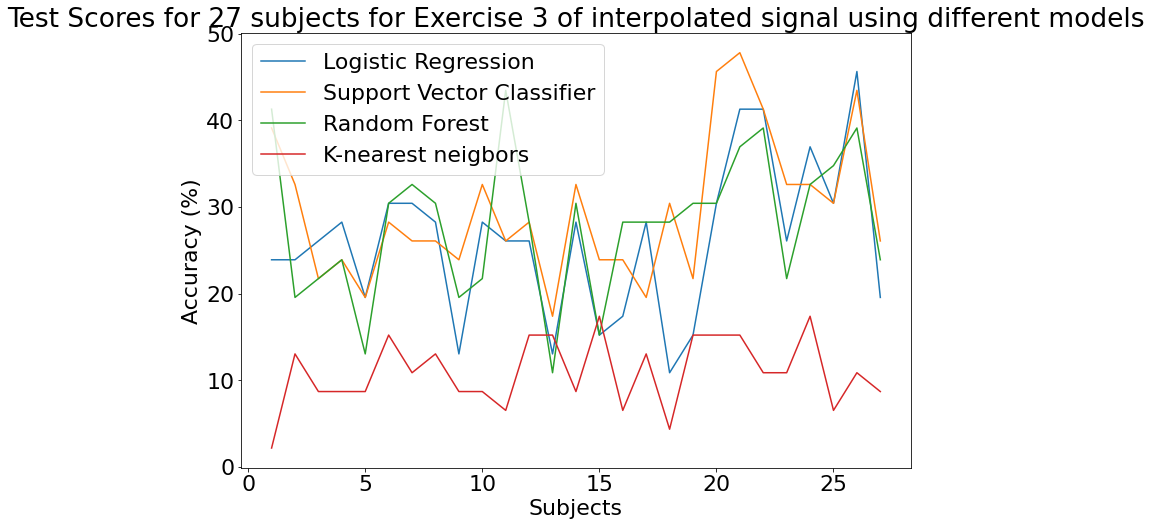

In [23]:
# Plot Average Accuracies for exercise 1
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12,8))
plt.rcParams.update({'font.size': 22})

for label, model in models.items():
    ax.plot(np.arange(1,28), test_accuracy_models_ex3[label])

ax.set_title("Test Scores for 27 subjects for Exercise 3 of interpolated signal using different models")
ax.set_xlabel("Subjects")
ax.set_ylabel("Accuracy (%)")
ax.legend(['Logistic Regression','Support Vector Classifier', 'Random Forest', 'K-nearest neigbors' ]);

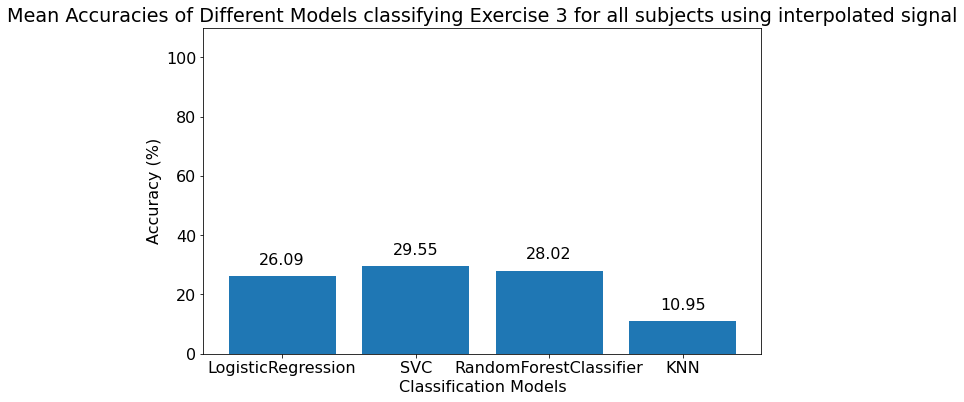

In [12]:
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 16})

mean_accuracies_ex3 = {}

for label, model in models.items():
    mean_accuracies_ex3[label] = np.mean(test_accuracy_models_ex3[label])

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 6))

ax.bar(mean_accuracies_ex3.keys(), mean_accuracies_ex3.values())
ax.set_title("Mean Accuracies of Different Models classifying Exercise 3 for all subjects using interpolated signal")
ax.set_xlabel("Classification Models")
ax.set_ylabel("Accuracy (%)")
ax.set_ylim(0, 110);

rects = ax.patches
for rect, label in zip(rects, mean_accuracies_ex3.values()):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width() / 2, height + 3, round(label, 2 ), ha='center', va='bottom')

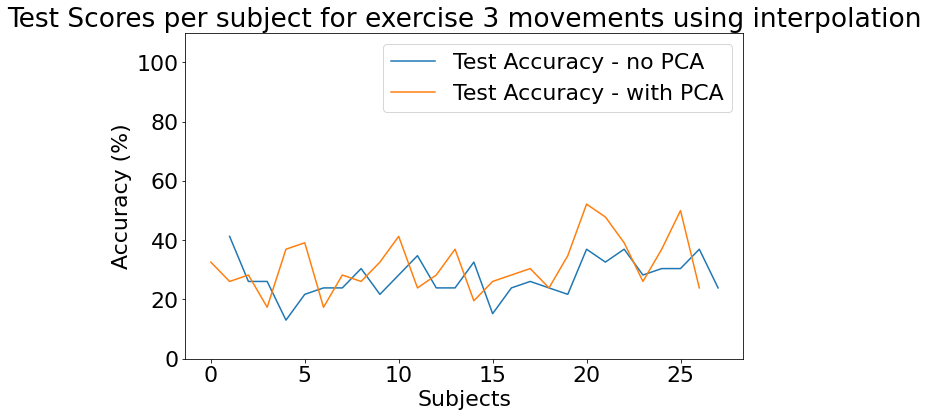

In [131]:
# Plot Average Accuracies for exercise 2
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,6))
plt.rcParams.update({'font.size': 22})

ax.plot(np.arange(1,28), test_acc_inter_subjects_ex3, test_acc_inter_subjects_ex3_pca)
ax.set_title("Test Scores per subject for exercise 3 movements using interpolation")
ax.set_xlabel("Subjects")
ax.set_ylabel("Accuracy (%)")
# ax.set_xticks(np.arange(1,28))
ax.set_ylim(0,110)
ax.legend(["Test Accuracy - no PCA", "Test Accuracy - with PCA"]);

### Comparing performance of RandomForestClassifier model on different Exercises with/without PCA

In [28]:
# Calculate means
ex1_mean_no_pca = round(np.mean(test_acc_inter_subjects_ex1),2)
ex2_mean_no_pca = round(np.mean(test_acc_inter_subjects_ex2),2)
ex3_mean_no_pca = round(np.mean(test_acc_inter_subjects_ex3),2)

# Calculate means
ex1_mean_pca = round(np.mean(test_acc_inter_subjects_ex1_pca),2)
ex2_mean_pca = round(np.mean(test_acc_inter_subjects_ex2_pca),2)
ex3_mean_pca = round(np.mean(test_acc_inter_subjects_ex3_pca),2)


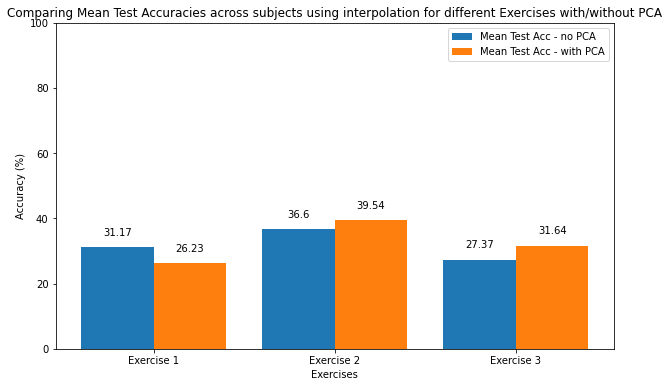

In [45]:
# Plot Bar graph to compare accuracy across exercises
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,6))

exercises = ["Exercise 1", "Exercise 2", "Exercise 3"]
mean_accs = [ ex1_mean_no_pca, ex2_mean_no_pca, ex3_mean_no_pca]
mean_accs_pca = [ ex1_mean_pca, ex2_mean_pca, ex3_mean_pca]

X_axis = np.arange(len(exercises))
ax.bar(X_axis - 0.2, mean_accs, 0.4, label="No PCA")
ax.bar(X_axis + 0.2, mean_accs_pca, 0.4, label="PCA")

ax.set_xticks(X_axis)
ax.set_title("Comparing Mean Test Accuracies across subjects using interpolation for different Exercises with/without PCA")
ax.set_xlabel("Exercises")
ax.set_ylabel("Accuracy (%)")
ax.set_ylim(0, 100)
ax.set_xticklabels(exercises);
ax.legend(["Mean Test Acc - no PCA", "Mean Test Acc - with PCA"])
rects = ax.patches
labels = np.append(mean_accs, mean_accs_pca)
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width() / 2, height + 3, round(label, 2 ), ha='center', va='bottom')

### Classification of exercise 1 movements using leave one out method and computing the average for all subjects using RandomForest Classifier and PCA 

Adding the data for all subjects except 1 to be training data and test the model on a subject it hasn't seen before.

In [19]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.decomposition import PCA

training_acc_subjects = []
test_acc_subjects = []

random_states = [0,1,10,42,66,73,99,100,101,200]
ex1_movements = list(range(1,13))

all_subjects_ex1 = pd.DataFrame()

for s in list(range(1,28)):
        data = load_data_DB1(subject=s, exercise=1)
        # Iterate over all movements and add them into a df
        for m in ex1_movements:
            all_subjects_ex1 = all_subjects_ex1.append(get_full_repetitions(data=data, movement=m),ignore_index=True)

print(f"all subjects data before interpolation: {all_subjects_ex1.shape}")

all subjects data before interpolation: (3240, 6001)


In [28]:
all_subjects_ex1

,0,1,2,3,4,5,6,7,8,9,...,5990,5991,5992,5993,5994,5995,5996,5997,5998,5999
0,0.0171,0.0073,0.0024,0.0024,0.0024,0.0024,0.0757,0.0317,0.0024,0.0146,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.0488,0.0073,0.0024,0.0024,0.0024,0.0024,0.0171,0.0488,0.0024,0.0049,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.0073,0.0073,0.0024,0.0024,0.0024,0.0024,0.0269,0.0391,0.0024,0.0049,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0.0049,0.0024,0.0024,0.0024,0.0024,0.0024,0.0659,0.0342,0.0024,0.0098,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.0024,0.0024,0.0024,0.0049,0.0024,0.0024,0.0098,0.0244,0.0049,0.0024,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3235,0.2075,0.0513,0.0049,0.0024,0.0049,0.0024,0.0049,0.2368,0.0024,0.0146,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3236,0.0537,0.0024,0.0049,0.0024,0.0049,0.0049,0.0049,0.1953,0.0049,0.0391,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3237,0.0391,0.0146,0.0073,0.0024,0.0024,0.0024,0.0049,0.1514,0.0049,0.0879,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3238,0.2246,0.0024,0.0049,0.0049,0.0049,0.0024,0.0049,0.3418,0.0024,0.0708,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [53]:
# Interpolate all subjects dataframe
all_subjects_ex1_interpolated = interpolate_dataframe(all_subjects_ex1)
print(f"The interpolated shape {all_subjects_ex1_interpolated.shape}")


The interpolated shape (3240, 6001)


In [54]:
all_subjects_ex1_interpolated

,0,1,2,3,4,5,6,7,8,9,...,5991,5992,5993,5994,5995,5996,5997,5998,5999,target
0,0.0171,0.01220,0.0073,0.00485,0.00240,0.0024,0.0024,0.0024,0.00240,0.0024,...,0.0024,0.0647,0.12700,0.09035,0.05370,0.02805,0.00240,0.01465,0.0269,1
1,0.0488,0.02805,0.0073,0.00485,0.00240,0.0024,0.0024,0.0024,0.00240,0.0024,...,0.0024,0.0024,0.05245,0.10250,0.05130,0.02685,0.00240,0.01340,0.0244,1
2,0.0073,0.00730,0.0073,0.00485,0.00240,0.0024,0.0024,0.0024,0.00240,0.0024,...,0.0024,0.0024,0.00610,0.00980,0.01950,0.01095,0.00240,0.01705,0.0317,1
3,0.0049,0.00365,0.0024,0.00240,0.00240,0.0024,0.0024,0.0024,0.00240,0.0024,...,0.0024,0.0024,0.03905,0.07570,0.05495,0.03420,0.01710,0.01100,0.0049,1
4,0.0024,0.00240,0.0024,0.00240,0.00365,0.0049,0.0024,0.0024,0.00610,0.0098,...,0.0024,0.0024,0.00240,0.00240,0.07080,0.03910,0.04885,0.05860,0.0220,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3235,0.2075,0.12940,0.0513,0.00490,0.00365,0.0024,0.0049,0.0024,0.00365,0.0049,...,0.0024,0.0049,0.00365,0.00240,0.00490,0.19040,0.09765,0.00490,0.0171,12
3236,0.0537,0.02805,0.0024,0.00490,0.00365,0.0024,0.0049,0.0049,0.00490,0.0049,...,0.0024,0.0049,0.00365,0.00240,0.00490,0.21730,0.11110,0.00490,0.0586,12
3237,0.0391,0.02685,0.0146,0.00730,0.00485,0.0024,0.0024,0.0024,0.00240,0.0049,...,0.0049,0.0049,0.00240,0.00240,0.00240,0.21730,0.11110,0.00490,0.0806,12
3238,0.2246,0.11350,0.0024,0.00490,0.00490,0.0049,0.0024,0.0049,0.34180,0.1721,...,0.0269,0.0159,0.00490,0.00490,0.00490,0.00490,0.24170,0.01710,0.0439,12


In [57]:
# Split to X & y
X = all_subjects_ex1_interpolated.drop("target", axis=1)
y = all_subjects_ex1_interpolated["target"]
   
print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")


X shape: (3240, 6000)
y shape: (3240,)


In [58]:
# Applying pca to get important components
pca = PCA(n_components=0.95)
X_transformed = pca.fit_transform(X)
print(f"The X_transformed shape {X_transformed.shape} ")
print(f"The y (labels) shape {y.shape} ")


The X_transformed shape (3240, 1076) 
The y (labels) shape (3240,) 


In [61]:
X_transformed_df = pd.DataFrame(X_transformed)
X_transformed_df

,0,1,2,3,4,5,6,7,8,9,...,1066,1067,1068,1069,1070,1071,1072,1073,1074,1075
0,-19.364160,-0.082583,-0.215994,0.448123,0.952483,0.071275,0.221422,0.290284,-0.190875,-0.098341,...,0.052007,-0.047178,0.063345,0.041486,-0.210935,0.002698,0.063678,0.021356,-0.062490,-0.019015
1,-18.213617,0.297402,-0.143437,1.244397,0.636765,0.090439,0.307322,0.177997,-0.294229,-0.034226,...,0.006830,0.034671,0.058846,-0.010538,0.106111,-0.016052,0.082158,0.030601,0.044831,-0.000610
2,-15.135418,-0.873060,0.357263,0.709249,0.265835,0.014439,0.024818,0.759524,-1.744753,-0.187797,...,-0.117632,-0.095802,0.136304,0.038915,0.035979,0.015651,0.280864,0.204337,0.109314,-0.051910
3,-8.138761,-6.354392,0.170736,0.149861,0.747006,0.236721,0.030119,-0.065643,-0.219081,-0.161214,...,0.233199,-0.129705,-0.243942,0.330737,0.258096,-0.023625,-0.111934,-0.168699,0.225238,0.294562
4,-18.464568,1.504969,1.079608,0.062187,0.925606,0.041598,0.185258,0.364288,-0.155821,-0.040909,...,-0.003039,-0.050104,-0.033891,0.026562,-0.160722,0.057121,0.087588,0.032602,0.072528,-0.086932
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3235,-8.313077,-3.619834,-1.375804,0.766783,1.439397,0.265675,0.133683,0.069503,-0.360007,-0.035089,...,0.165052,0.446453,-0.144362,-0.242619,0.056178,-0.450865,0.571486,1.104698,0.178967,-0.164700
3236,-13.993303,-1.598745,-2.050972,1.692547,-0.508190,0.007655,0.040364,0.035793,-0.344824,-0.069931,...,0.022172,0.020044,0.074466,-0.062355,-0.194499,0.194174,0.341271,-0.203964,0.095888,-0.092220
3237,-10.136506,-6.128655,-2.664535,2.810638,-0.378744,-0.105223,0.160236,-0.599673,-0.432317,-0.018949,...,-0.214167,0.003124,-0.013922,0.018346,-0.373217,0.137575,0.239284,0.532250,-0.568404,0.272457
3238,-14.739628,-0.630603,0.431091,-0.207432,0.412604,0.028130,0.042384,0.239237,-0.036274,-0.093793,...,0.336246,0.380566,-0.049764,-0.193575,0.102025,-0.167991,0.111685,0.076401,-0.078514,0.073812


In [63]:
X_transformed_df[0:120]


,0,1,2,3,4,5,6,7,8,9,...,1066,1067,1068,1069,1070,1071,1072,1073,1074,1075
0,-19.364160,-0.082583,-0.215994,0.448123,0.952483,0.071275,0.221422,0.290284,-0.190875,-0.098341,...,0.052007,-0.047178,0.063345,0.041486,-0.210935,0.002698,0.063678,0.021356,-0.062490,-0.019015
1,-18.213617,0.297402,-0.143437,1.244397,0.636765,0.090439,0.307322,0.177997,-0.294229,-0.034226,...,0.006830,0.034671,0.058846,-0.010538,0.106111,-0.016052,0.082158,0.030601,0.044831,-0.000610
2,-15.135418,-0.873060,0.357263,0.709249,0.265835,0.014439,0.024818,0.759524,-1.744753,-0.187797,...,-0.117632,-0.095802,0.136304,0.038915,0.035979,0.015651,0.280864,0.204337,0.109314,-0.051910
3,-8.138761,-6.354392,0.170736,0.149861,0.747006,0.236721,0.030119,-0.065643,-0.219081,-0.161214,...,0.233199,-0.129705,-0.243942,0.330737,0.258096,-0.023625,-0.111934,-0.168699,0.225238,0.294562
4,-18.464568,1.504969,1.079608,0.062187,0.925606,0.041598,0.185258,0.364288,-0.155821,-0.040909,...,-0.003039,-0.050104,-0.033891,0.026562,-0.160722,0.057121,0.087588,0.032602,0.072528,-0.086932
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115,-20.262709,1.295280,0.208840,0.554604,0.678108,0.060914,0.177285,0.238435,-0.198783,-0.155969,...,0.006731,-0.031679,0.002268,-0.024111,-0.013856,-0.037181,-0.017724,-0.013578,-0.052760,-0.015009
116,-19.721304,2.412614,0.067579,0.554208,1.095436,0.142132,0.262465,0.363847,-0.207527,-0.088098,...,0.007754,-0.098173,0.052188,0.008964,-0.038681,0.115341,0.017556,0.023120,0.043624,0.035550
117,-20.742528,1.542573,0.411286,0.573092,0.690270,0.080347,0.229269,0.264955,-0.142091,-0.078338,...,-0.092242,-0.025017,-0.030277,-0.010268,-0.013576,0.027589,-0.002090,-0.015382,0.065111,0.067853
118,-17.558145,0.299288,1.088715,-0.029827,1.220710,0.081994,0.154073,0.368353,-0.264387,-0.090248,...,0.001388,-0.073783,-0.014303,0.131152,-0.009405,0.037874,0.082901,-0.024933,-0.093174,-0.027887


In [68]:
np.random.seed(42)

# Iterate over 27 subjects of Database 1 and trying to classify exercise 1 
for sub in list(range(1,28)):
    print(f"Current Left Out Subject is: {sub} ")
    
    # Drop the rows that correspond to the test and prepare X_train & y_train for the model
    current_sub_start_idx = (sub - 1) * 120
    X_train = X_transformed_df.drop(X_transformed_df.index[current_sub_start_idx:current_sub_start_idx+120])
    y_train = y.drop(y.index[current_sub_start_idx:current_sub_start_idx+120])
    
#     print(f"Training Data without left-out subject shape: {X_train.shape}")
#     print(f"Training Labels without left-out subject shape: {y_train.shape}")
    
    # Prepare X_test & y_test
    X_test = X_transformed_df[current_sub_start_idx:current_sub_start_idx+120]
    y_test = y[current_sub_start_idx:current_sub_start_idx+120]
  
#     print(f"Test Data without left-out subject shape: {X_test.shape}")
#     print(f"Test Labels without left-out subject shape: {y_test.shape}")
  
    clf = RandomForestClassifier(n_estimators=100)
    clf.fit(X_train, y_train)
    
    
    training_score = clf.score(X_train, y_train)
    test_score = clf.score(X_test, y_test)
    training_acc_subjects.append(training_score)
    test_acc_subjects.append(test_score)
    
    # Display the subject results
    print(f"The training accuracy leave subject {sub} out is {training_score}")
    print(f"The test accuracy leave subject {sub} out is {test_score}")
    print("-------------------------------------------------------------")
    
print(f"Average Training Accuracies leaving each subject out once is {np.mean(training_acc_subjects)}")
print(f"Average Test Accuracies leaving each subject out once is {np.mean(test_acc_subjects)}")
    
   

Current Left Out Subject is: 1 
The training accuracy leave subject 1 out is 1.0
The test accuracy leave subject 1 out is 0.19166666666666668
-------------------------------------------------------------
Current Left Out Subject is: 2 
The training accuracy leave subject 2 out is 1.0
The test accuracy leave subject 2 out is 0.16666666666666666
-------------------------------------------------------------
Current Left Out Subject is: 3 
The training accuracy leave subject 3 out is 1.0
The test accuracy leave subject 3 out is 0.16666666666666666
-------------------------------------------------------------
Current Left Out Subject is: 4 
The training accuracy leave subject 4 out is 1.0
The test accuracy leave subject 4 out is 0.10833333333333334
-------------------------------------------------------------
Current Left Out Subject is: 5 
The training accuracy leave subject 5 out is 1.0
The test accuracy leave subject 5 out is 0.20833333333333334
------------------------------------------

### Classification of exercise 2 movements using leave one out method and computing the average for all subjects using RandomForest Classifier and PCA 

Adding the data for all subjects except 1 subject to be training data and test the model on a subject it hasn't seen before.

In [76]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.decomposition import PCA

training_acc_subjects = []
test_acc_subjects = []

random_states = [0,1,10,42,66,73,99,100,101,200]
ex2_movements = list(range(1,18))

all_subjects_ex2 = pd.DataFrame()

for s in list(range(1,28)):
        data = load_data_DB1(subject=s, exercise=2)
        # Iterate over all movements and add them into a df
        for m in ex2_movements:
            all_subjects_ex2 = all_subjects_ex2.append(get_full_repetitions(data=data, movement=m),ignore_index=True)

print(f"all subjects data before interpolation: {all_subjects_ex2.shape}")

all subjects data before interpolation: (4590, 5991)


In [77]:
# Interpolate all subjects dataframe
all_subjects_ex2_interpolated = interpolate_dataframe(all_subjects_ex2)
print(f"The interpolated shape {all_subjects_ex2_interpolated.shape}")


The interpolated shape (4590, 5991)


In [78]:
# Split to X & y
X = all_subjects_ex2_interpolated.drop("target", axis=1)
y = all_subjects_ex2_interpolated["target"]
   
print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")


X shape: (4590, 5990)
y shape: (4590,)


In [79]:
# Applying pca to get important components
pca = PCA(n_components=0.95)
X_transformed = pca.fit_transform(X)
print(f"The X_transformed shape {X_transformed.shape} ")
print(f"The y (labels) shape {y.shape} ")

X_transformed_df = pd.DataFrame(X_transformed)


The X_transformed shape (4590, 1318) 
The y (labels) shape (4590,) 


In [80]:
np.random.seed(42)

# Iterate over 27 subjects of Database 1 and trying to classify exercise 2
for sub in list(range(1,28)):
    print(f"Current Left Out Subject is: {sub} ")
    
    # Drop the rows that correspond to the test and prepare X_train & y_train for the model
    current_sub_start_idx = (sub - 1) * 170
    X_train = X_transformed_df.drop(X_transformed_df.index[current_sub_start_idx:current_sub_start_idx+170])
    y_train = y.drop(y.index[current_sub_start_idx:current_sub_start_idx+170])
    
#     print(f"Training Data without left-out subject shape: {X_train.shape}")
#     print(f"Training Labels without left-out subject shape: {y_train.shape}")
    
    # Prepare X_test & y_test
    X_test = X_transformed_df[current_sub_start_idx:current_sub_start_idx+170]
    y_test = y[current_sub_start_idx:current_sub_start_idx+170]
  
#     print(f"Test Data without left-out subject shape: {X_test.shape}")
#     print(f"Test Labels without left-out subject shape: {y_test.shape}")
  
    clf = RandomForestClassifier(n_estimators=100)
    clf.fit(X_train, y_train)
    
    
    training_score = clf.score(X_train, y_train)
    test_score = clf.score(X_test, y_test)
    training_acc_subjects.append(training_score)
    test_acc_subjects.append(test_score)
    
    # Display the subject results
    print(f"The training accuracy leave subject {sub} out for exercise 2 is {training_score}")
    print(f"The test accuracy leave subject {sub} out for exercise 2  is {test_score}")
    print("-------------------------------------------------------------")
    
print(f"Average Training Accuracies leaving each subject out once for exercise 2 is {np.mean(training_acc_subjects)}")
print(f"Average Test Accuracies leaving each subject out once for exercise 2 is {np.mean(test_acc_subjects)}")
    
   

Current Left Out Subject is: 1 
The training accuracy leave subject 1 out for exercise 2 is 1.0
The test accuracy leave subject 1 out for exercise 2  is 0.16470588235294117
-------------------------------------------------------------
Current Left Out Subject is: 2 
The training accuracy leave subject 2 out for exercise 2 is 1.0
The test accuracy leave subject 2 out for exercise 2  is 0.17058823529411765
-------------------------------------------------------------
Current Left Out Subject is: 3 
The training accuracy leave subject 3 out for exercise 2 is 1.0
The test accuracy leave subject 3 out for exercise 2  is 0.15294117647058825
-------------------------------------------------------------
Current Left Out Subject is: 4 
The training accuracy leave subject 4 out for exercise 2 is 1.0
The test accuracy leave subject 4 out for exercise 2  is 0.11176470588235295
-------------------------------------------------------------
Current Left Out Subject is: 5 
The training accuracy leave 

### Classification of exercise 3  movements using leave one out method and computing the average for all subjects using RandomForest Classifier and PCA 

Adding the data for all subjects except 1 subject to be training data and test the model on a subject it hasn't seen before.


In [81]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.decomposition import PCA

training_acc_subjects = []
test_acc_subjects = []

random_states = [0,1,10,42,66,73,99,100,101,200]
ex3_movements = list(range(1,24))

all_subjects_ex3 = pd.DataFrame()

for s in list(range(1,28)):
        data = load_data_DB1(subject=s, exercise=3)
        # Iterate over all movements and add them into a df
        for m in ex3_movements:
            all_subjects_ex3 = all_subjects_ex3.append(get_full_repetitions(data=data, movement=m),ignore_index=True)

print(f"all subjects data before interpolation: {all_subjects_ex3.shape}")


all subjects data before interpolation: (6210, 6611)


In [82]:
# Interpolate all subjects dataframe
all_subjects_ex3_interpolated = interpolate_dataframe(all_subjects_ex3)
print(f"The interpolated shape {all_subjects_ex3_interpolated.shape}")

The interpolated shape (6210, 6611)


In [83]:
# Split to X & y
X = all_subjects_ex3_interpolated.drop("target", axis=1)
y = all_subjects_ex3_interpolated["target"]
   
print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")

X shape: (6210, 6610)
y shape: (6210,)


In [84]:
# Applying pca to get important components
pca = PCA(n_components=0.95)
X_transformed = pca.fit_transform(X)
print(f"The X_transformed shape {X_transformed.shape} ")
print(f"The y (labels) shape {y.shape} ")

X_transformed_df = pd.DataFrame(X_transformed)

The X_transformed shape (6210, 1511) 
The y (labels) shape (6210,) 


In [85]:

np.random.seed(42)

# Iterate over 27 subjects of Database 1 and trying to classify exercise 2
for sub in list(range(1,28)):
    print(f"Current Left Out Subject is: {sub} ")
    
    # Drop the rows that correspond to the test and prepare X_train & y_train for the model
    current_sub_start_idx = (sub - 1) * 230
    X_train = X_transformed_df.drop(X_transformed_df.index[current_sub_start_idx:current_sub_start_idx+230])
    y_train = y.drop(y.index[current_sub_start_idx:current_sub_start_idx+230])
    
#     print(f"Training Data without left-out subject shape: {X_train.shape}")
#     print(f"Training Labels without left-out subject shape: {y_train.shape}")
    
    # Prepare X_test & y_test
    X_test = X_transformed_df[current_sub_start_idx:current_sub_start_idx+230]
    y_test = y[current_sub_start_idx:current_sub_start_idx+230]
  
#     print(f"Test Data without left-out subject shape: {X_test.shape}")
#     print(f"Test Labels without left-out subject shape: {y_test.shape}")
  
    clf = RandomForestClassifier(n_estimators=100)
    clf.fit(X_train, y_train)
    
    
    training_score = clf.score(X_train, y_train)
    test_score = clf.score(X_test, y_test)
    training_acc_subjects.append(training_score)
    test_acc_subjects.append(test_score)
    
    # Display the subject results
    print(f"The training accuracy leave subject {sub} out for exercise 3 is {training_score}")
    print(f"The test accuracy leave subject {sub} out for exercise 3  is {test_score}")
    print("-------------------------------------------------------------")
    
print(f"Average Training Accuracies leaving each subject out once for exercise 3 is {np.mean(training_acc_subjects)}")
print(f"Average Test Accuracies leaving each subject out once for exercise 3 is {np.mean(test_acc_subjects)}")
    
   

Current Left Out Subject is: 1 
The training accuracy leave subject 1 out for exercise 3 is 1.0
The test accuracy leave subject 1 out for exercise 3  is 0.13043478260869565
-------------------------------------------------------------
Current Left Out Subject is: 2 
The training accuracy leave subject 2 out for exercise 3 is 1.0
The test accuracy leave subject 2 out for exercise 3  is 0.08695652173913043
-------------------------------------------------------------
Current Left Out Subject is: 3 
The training accuracy leave subject 3 out for exercise 3 is 1.0
The test accuracy leave subject 3 out for exercise 3  is 0.14782608695652175
-------------------------------------------------------------
Current Left Out Subject is: 4 
The training accuracy leave subject 4 out for exercise 3 is 1.0
The test accuracy leave subject 4 out for exercise 3  is 0.09565217391304348
-------------------------------------------------------------
Current Left Out Subject is: 5 
The training accuracy leave 

### Classification of all exercises movements combined using interpolation and computing the average for all subjects using RandomForest Classifier and PCA 


In [14]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

models = {"LogisticRegression": LogisticRegression(max_iter=10000, n_jobs=-1),
         "SVC": SVC(kernel='rbf'),
         "RandomForestClassifier": RandomForestClassifier(n_estimators=100, n_jobs=-1),
         "KNN": KNeighborsClassifier(n_neighbors=5, n_jobs=-1)}

In [16]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.decomposition import PCA

test_accuracy_models_all = {}

# Initialize lists for each model .. Each list should contain 27 values(number of subjects)
for label, model in models.items():
    test_accuracy_models_all[label] = []


# random_states = [0,1,10,42,66,73,99,100,101,200]
ex1_movements = list(range(1,13))
ex2_movements = list(range(1,18))
ex3_movements = list(range(1,24))

# Iterate Over all subjects and claculate their training and test accuracies for all movements combined
for s in list(range(1,28)):

    all_exercises_df = pd.DataFrame()

    ex1_df = pd.DataFrame()
    data = load_data_DB1(subject=s, exercise=1)
    # Iterate over all movements and add them into a df
    for m in ex1_movements:
        ex1_df = ex1_df.append(get_full_repetitions(data=data, movement=m),ignore_index=True)
        
    ex2_df = pd.DataFrame()
    data = load_data_DB1(subject=s, exercise=2)
    # Iterate over all movements and add them into a df
    for m in ex2_movements:
        ex2_df = ex2_df.append(get_full_repetitions(data=data, movement=m),ignore_index=True)
    
    ex2_df["target"] = ex2_df["target"] + 12
    
    ex3_df = pd.DataFrame()
    data = load_data_DB1(subject=s, exercise=3)
    # Iterate over all movements and add them into a df
    for m in ex3_movements:
        ex3_df = ex3_df.append(get_full_repetitions(data=data, movement=m),ignore_index=True)
        
    ex3_df["target"] = ex3_df["target"] + 12 + 17
    
    all_exercises_df = all_exercises_df.append(ex1_df, ignore_index=True)
    all_exercises_df = all_exercises_df.append(ex2_df, ignore_index=True)
    all_exercises_df = all_exercises_df.append(ex3_df, ignore_index=True)

    # Interpolate to make all movements repetitions have the same length
    all_exercises_df_interpolated = interpolate_dataframe(all_exercises_df)

    X = all_exercises_df_interpolated.drop("target", axis=1)
    y = all_exercises_df_interpolated["target"]
    
#     # Apply PCA
#     pca = PCA(n_components=0.95)
#     X_transformed = pca.fit_transform(X)
    
# #     subject_training_scores = []
#     subject_test_scores = []
        
    # Split into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    for label, model in models.items():
        model.fit(X_train, y_train)
        score = round(model.score(X_test, y_test) * 100, 3)
        test_accuracy_models_all[label].append(score)
        print(f"Test Accuracy for subject {s} for 52 movements using {label} is {score}")
    
    print("-----------------------------------------------------------------------------------")

    
for label, model in models.items():
    print(f"Average Test Accuracy for all subjects for 52 movements using {label} {np.mean(test_accuracy_models_all[label])}")


Test Accuracy for subject 1 for 52 movements using LogisticRegression is 20.192
Test Accuracy for subject 1 for 52 movements using SVC is 7.692
Test Accuracy for subject 1 for 52 movements using RandomForestClassifier is 25.0
Test Accuracy for subject 1 for 52 movements using KNN is 4.808
-----------------------------------------------------------------------------------
Test Accuracy for subject 2 for 52 movements using LogisticRegression is 13.462
Test Accuracy for subject 2 for 52 movements using SVC is 4.808
Test Accuracy for subject 2 for 52 movements using RandomForestClassifier is 16.346
Test Accuracy for subject 2 for 52 movements using KNN is 3.846
-----------------------------------------------------------------------------------
Test Accuracy for subject 3 for 52 movements using LogisticRegression is 13.462
Test Accuracy for subject 3 for 52 movements using SVC is 1.923
Test Accuracy for subject 3 for 52 movements using RandomForestClassifier is 9.615
Test Accuracy for subje

Test Accuracy for subject 23 for 52 movements using LogisticRegression is 15.385
Test Accuracy for subject 23 for 52 movements using SVC is 9.615
Test Accuracy for subject 23 for 52 movements using RandomForestClassifier is 20.192
Test Accuracy for subject 23 for 52 movements using KNN is 5.769
-----------------------------------------------------------------------------------
Test Accuracy for subject 24 for 52 movements using LogisticRegression is 21.154
Test Accuracy for subject 24 for 52 movements using SVC is 9.615
Test Accuracy for subject 24 for 52 movements using RandomForestClassifier is 22.115
Test Accuracy for subject 24 for 52 movements using KNN is 7.692
-----------------------------------------------------------------------------------
Test Accuracy for subject 25 for 52 movements using LogisticRegression is 24.038
Test Accuracy for subject 25 for 52 movements using SVC is 14.423
Test Accuracy for subject 25 for 52 movements using RandomForestClassifier is 30.769
Test Acc

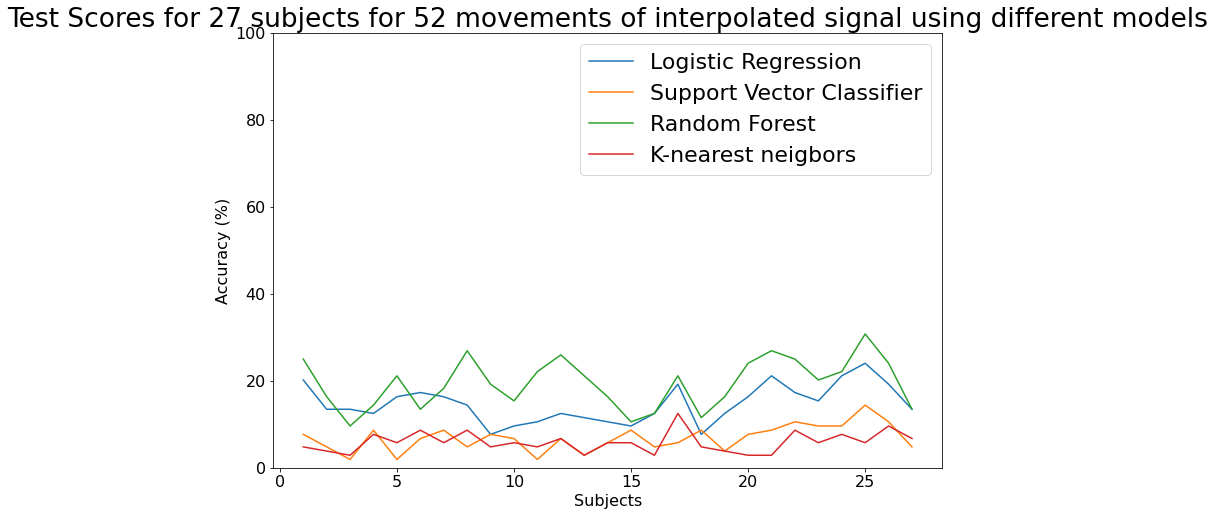

In [19]:
# Plot Average Accuracies for exercise 1
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12,8))
plt.rcParams.update({'font.size': 22})

for label, model in models.items():
    ax.plot(np.arange(1,28), test_accuracy_models_all[label])

ax.set_title("Test Scores for 27 subjects for 52 movements of interpolated signal using different models")
ax.set_xlabel("Subjects")
ax.set_ylabel("Accuracy (%)")
ax.set_ylim(0,100)
ax.legend(['Logistic Regression','Support Vector Classifier', 'Random Forest', 'K-nearest neigbors' ]);

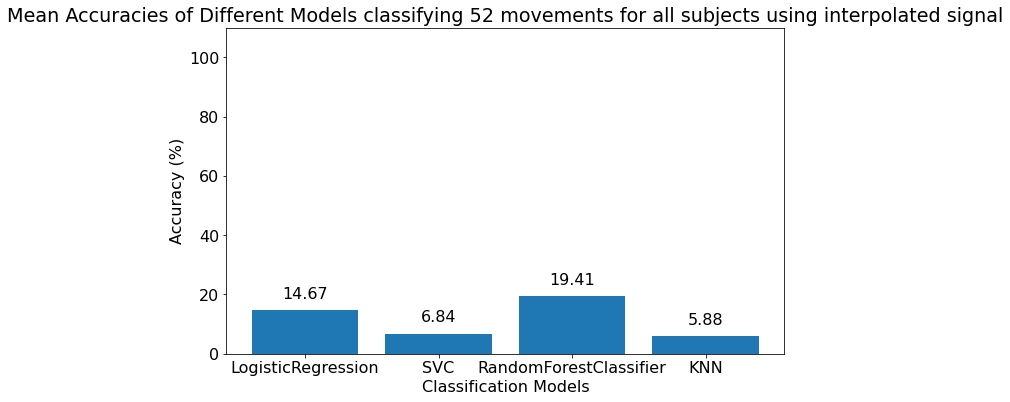

In [18]:
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 16})

mean_accuracies_all = {}

for label, model in models.items():
    mean_accuracies_all[label] = np.mean(test_accuracy_models_all[label])

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 6))

ax.bar(mean_accuracies_all.keys(), mean_accuracies_all.values())
ax.set_title("Mean Accuracies of Different Models classifying 52 movements for all subjects using interpolated signal")
ax.set_xlabel("Classification Models")
ax.set_ylabel("Accuracy (%)")
ax.set_ylim(0, 110);

rects = ax.patches
for rect, label in zip(rects, mean_accuracies_all.values()):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width() / 2, height + 3, round(label, 2 ), ha='center', va='bottom')

In [22]:
for i, x in enumerate(test_acc_subjects_allMoves_interp):
    test_acc_subjects_allMoves_interp[i] = x / 100
np.mean(test_acc_subjects_allMoves_interp)

17.058404558404558

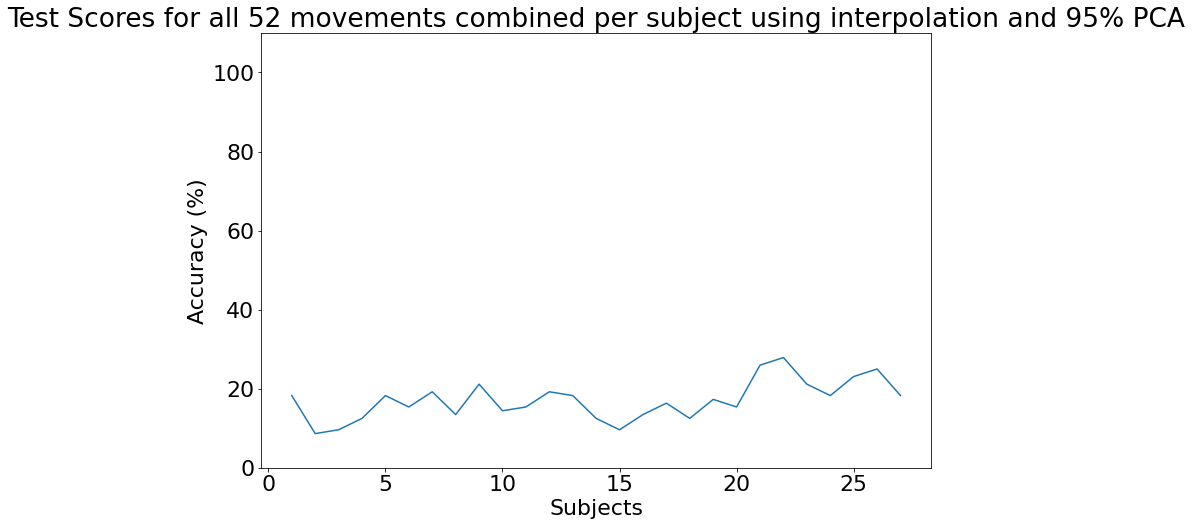

In [20]:
# Plot Average Accuracies for exercise 1
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12,8))
plt.rcParams.update({'font.size': 22})

ax.plot(np.arange(1,28), test_acc_subjects_allMoves_interp)
ax.set_title("Test Scores for all 52 movements combined per subject using interpolation and 95% PCA")
ax.set_xlabel("Subjects")
ax.set_ylabel("Accuracy (%)");
ax.set_ylim(0,110);
# ax.set_xticks(np.arange(1,28));

## Visualizing Interpolation

**Subject 11 Exercise 2 Movement 12 Repetition 3**

In [112]:
data = load_data_DB1(subject=11, exercise=2)

move_without_interpolation = get_full_repetitions(data=data, movement=12)
move_without_interpolation.head()

,0,1,2,3,4,5,6,7,8,9,...,4491,4492,4493,4494,4495,4496,4497,4498,4499,target
0,0.0024,0.0122,0.0024,0.0073,0.0049,0.0024,0.0171,0.0244,0.0024,0.0415,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12
1,0.0024,0.0024,0.0415,0.0195,0.0024,0.0024,0.4004,0.1440,0.0098,0.4321,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12
2,0.0049,0.0024,0.0024,0.0024,0.0024,0.0146,0.4517,0.1172,0.0073,0.2197,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12
3,0.0024,0.0024,0.0269,0.0684,0.0024,0.0098,0.5005,0.2393,0.0244,0.2539,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12
4,0.0024,0.0024,0.0171,0.0171,0.0024,0.0024,0.0732,0.1099,0.0024,0.0854,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12


In [113]:
move_interpolated = interpolate_dataframe(move_without_interpolation)
move_interpolated.head()

,0,1,2,3,4,5,6,7,8,9,...,4491,4492,4493,4494,4495,4496,4497,4498,4499,target
0,0.0024,0.00730,0.0122,0.0024,0.0073,0.0049,0.0024,0.0171,0.0244,0.01340,...,0.1172,0.07815,0.0391,0.0024,0.0562,0.9375,0.1978,0.1025,0.5908,12
1,0.0024,0.00240,0.0024,0.0415,0.0195,0.0024,0.0024,0.4004,0.1440,0.00980,...,0.0049,0.01460,0.0024,0.0024,0.0488,0.7690,0.1953,0.0293,0.4419,12
2,0.0049,0.00365,0.0024,0.0024,0.0024,0.0024,0.0146,0.4517,0.1172,0.06225,...,0.0293,0.01585,0.0024,0.0024,0.0195,0.7446,0.3247,0.0244,0.5347,12
3,0.0024,0.00240,0.0024,0.0269,0.0684,0.0024,0.0098,0.5005,0.2393,0.13185,...,0.1904,0.16110,0.1318,0.0024,0.0464,0.6689,0.1807,0.1587,0.4395,12
4,0.0024,0.00240,0.0024,0.0171,0.0171,0.0024,0.0024,0.0732,0.1099,0.05615,...,0.0757,0.04275,0.0098,0.0049,0.0317,0.4639,0.1367,0.0879,0.2881,12


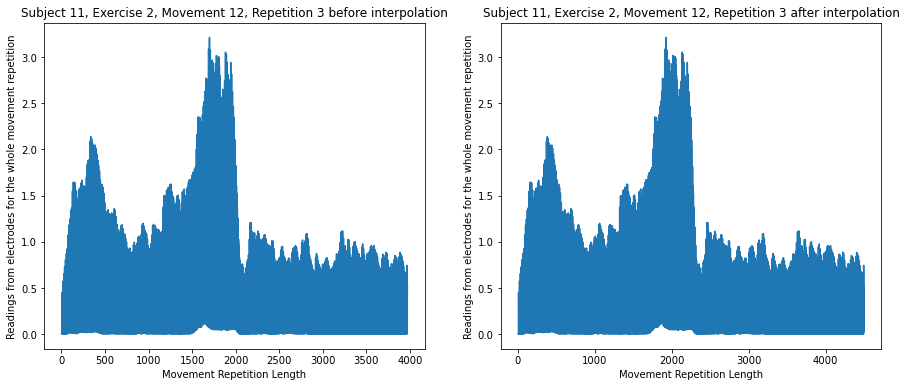

In [115]:
import matplotlib.pyplot as plt

r1 = np.arange(0, move_without_interpolation.shape[1] - 1)
r2 = np.arange(0, move_interpolated.shape[1] - 1)

rep = 2

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))
axes[0].plot(r1, move_without_interpolation.iloc[rep].drop("target"))
axes[0].set_title("Subject 11, Exercise 2, Movement 12, Repetition 3 before interpolation")
axes[0].set_xlabel("Movement Repetition Length")
axes[0].set_ylabel("Readings from electrodes for the whole movement repetition")
axes[1].plot(r2, move_interpolated.iloc[rep].drop("target"));
axes[1].set_title("Subject 11, Exercise 2, Movement 12, Repetition 3 after interpolation")
axes[1].set_xlabel("Movement Repetition Length")
axes[1].set_ylabel("Readings from electrodes for the whole movement repetition");

**Subject 19 Exercise 3 Movement 5 Repetition 10**

In [96]:
data = load_data_DB1(subject=19, exercise=3)

move_without_interpolation = get_full_repetitions(data=data, movement=5)
move_without_interpolation.head()

,0,1,2,3,4,5,6,7,8,9,...,5531,5532,5533,5534,5535,5536,5537,5538,5539,target
0,0.4419,0.1416,0.0024,0.0024,0.0024,0.0024,0.1294,0.3760,0.0024,0.2173,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5
1,0.3003,0.0195,0.0220,0.0024,0.0024,0.0024,0.1953,0.5737,0.0024,0.2197,...,0.0952,0.0024,0.0024,0.0024,0.0024,0.1147,0.0391,0.0024,0.0024,5
2,0.2002,0.0415,0.0024,0.0024,0.0024,0.0122,0.2856,1.0059,0.0024,0.4639,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5
3,0.1880,0.0171,0.0024,0.0024,0.0024,0.0024,0.0220,0.0146,0.0024,0.0024,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5
4,0.0269,0.0024,0.0024,0.0024,0.0024,0.0342,0.2100,0.6934,0.0024,0.2734,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5


In [97]:
move_interpolated = interpolate_dataframe(move_without_interpolation)
move_interpolated.head()

,0,1,2,3,4,5,6,7,8,9,...,5531,5532,5533,5534,5535,5536,5537,5538,5539,target
0,0.4419,0.29175,0.1416,0.0024,0.00240,0.0024,0.0024,0.1294,0.3760,0.0024,...,0.07080,0.0024,0.00240,0.0024,0.00240,0.1343,0.27830,0.0024,0.0439,5
1,0.3003,0.01950,0.0220,0.0024,0.00240,0.0024,0.1953,0.5737,0.0024,0.2197,...,0.09520,0.0024,0.00240,0.0024,0.00240,0.1147,0.03910,0.0024,0.0024,5
2,0.2002,0.14730,0.0944,0.0415,0.02195,0.0024,0.0024,0.0024,0.0024,0.0024,...,0.09395,0.1855,0.19165,0.1978,0.10010,0.0024,0.05615,0.1099,0.1099,5
3,0.1880,0.10255,0.0171,0.0024,0.00240,0.0024,0.0024,0.0220,0.0146,0.0024,...,0.03420,0.0024,0.00240,0.0024,0.00240,0.0024,0.00240,0.0024,0.0024,5
4,0.0269,0.01465,0.0024,0.0024,0.00240,0.0024,0.0024,0.0024,0.0183,0.0342,...,0.00240,0.0049,0.17945,0.3540,0.22585,0.0977,0.00240,0.0256,0.0488,5


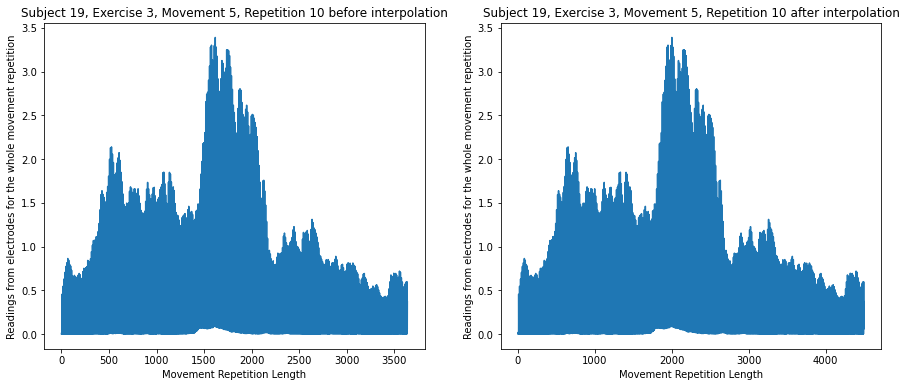

In [116]:
import matplotlib.pyplot as plt

r1 = np.arange(0, move_without_interpolation.shape[1] - 1)
r2 = np.arange(0, move_interpolated.shape[1] - 1)

rep = 9

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))
axes[0].plot(r1, move_without_interpolation.iloc[rep].drop("target"))
axes[0].set_title("Subject 19, Exercise 3, Movement 5, Repetition 10 before interpolation")
axes[0].set_xlabel("Movement Repetition Length")
axes[0].set_ylabel("Readings from electrodes for the whole movement repetition")
axes[1].plot(r2, move_interpolated.iloc[rep].drop("target"));
axes[1].set_title("Subject 19, Exercise 3, Movement 5, Repetition 10 after interpolation")
axes[1].set_xlabel("Movement Repetition Length")
axes[1].set_ylabel("Readings from electrodes for the whole movement repetition");

**Subject 5 Exercise 1 Movement 10 Repetition 1** 

In [117]:
data = load_data_DB1(subject=5, exercise=1)

move_without_interpolation = get_full_repetitions(data=data, movement=10)
move_without_interpolation.head()

,0,1,2,3,4,5,6,7,8,9,...,5811,5812,5813,5814,5815,5816,5817,5818,5819,target
0,0.0024,0.0439,0.0024,0.0024,0.0024,0.0024,0.1514,0.3076,0.0098,0.1392,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10
1,0.0024,0.0781,0.0122,0.0024,0.0024,0.0024,0.1880,0.4321,0.0024,0.3589,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10
2,0.0024,0.0171,0.0024,0.0024,0.0024,0.0024,0.0928,0.3442,0.0073,0.2051,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10
3,0.0024,0.0806,0.0049,0.0024,0.0024,0.0024,0.1416,0.3247,0.0610,0.2612,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10
4,0.0098,0.1294,0.0024,0.0024,0.0024,0.0024,0.0439,0.2075,0.0269,0.1514,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10


In [119]:
move_interpolated = interpolate_dataframe(move_without_interpolation)
move_interpolated.head()

,0,1,2,3,4,5,6,7,8,9,...,5811,5812,5813,5814,5815,5816,5817,5818,5819,target
0,0.0024,0.02315,0.0439,0.00240,0.0024,0.0024,0.0024,0.1514,0.3076,0.1587,...,0.0439,0.07930,0.1147,0.0049,0.0293,0.4370,1.0889,0.0879,0.5957,10
1,0.0024,0.04025,0.0781,0.01220,0.0073,0.0024,0.0024,0.0024,0.0024,0.1880,...,0.0354,0.00240,0.0024,0.0244,0.0464,0.1538,0.1123,0.0708,0.0562,10
2,0.0024,0.00975,0.0171,0.00240,0.0024,0.0024,0.0024,0.0928,0.3442,0.0073,...,0.1807,0.05370,0.0806,0.0073,0.0342,0.3955,1.1011,0.1001,0.8032,10
3,0.0024,0.04150,0.0806,0.04275,0.0049,0.0024,0.0024,0.0024,0.0024,0.0720,...,0.0024,0.00365,0.0049,0.0391,0.1050,0.1709,0.0488,0.1001,0.1514,10
4,0.0098,0.06960,0.1294,0.00240,0.0024,0.0024,0.0024,0.0439,0.2075,0.0269,...,0.1733,0.04390,0.0244,0.0024,0.0244,0.2466,0.9009,0.1196,0.5786,10


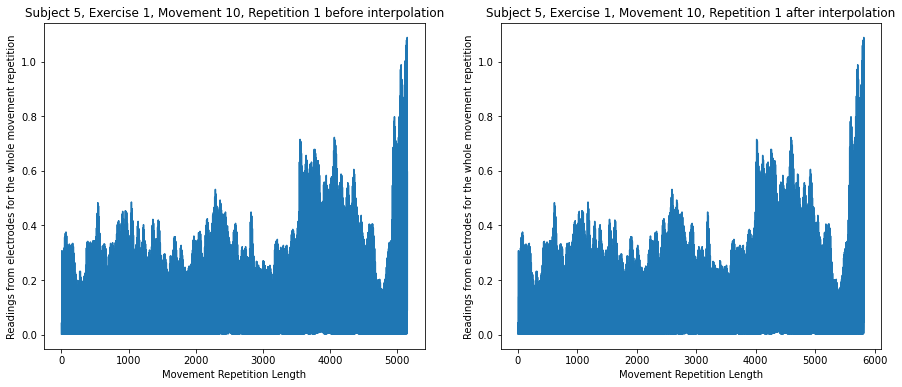

In [120]:
import matplotlib.pyplot as plt

r1 = np.arange(0, move_without_interpolation.shape[1] - 1)
r2 = np.arange(0, move_interpolated.shape[1] - 1)

rep = 0

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))
axes[0].plot(r1, move_without_interpolation.iloc[rep].drop("target"))
axes[0].set_title("Subject 5, Exercise 1, Movement 10, Repetition 1 before interpolation")
axes[0].set_xlabel("Movement Repetition Length")
axes[0].set_ylabel("Readings from electrodes for the whole movement repetition")
axes[1].plot(r2, move_interpolated.iloc[rep].drop("target"));
axes[1].set_title("Subject 5, Exercise 1, Movement 10, Repetition 1 after interpolation")
axes[1].set_xlabel("Movement Repetition Length")
axes[1].set_ylabel("Readings from electrodes for the whole movement repetition");

In [118]:
X = move_interpolated.drop("target", axis=1)
y = move_interpolated["target"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

clf= RandomForestClassifier(n_estimators=100)

clf.fit(X_train, y_train)

clf.score(X_test, y_test)

1.0

In [145]:
X_test

,0,1,2,3,4,5,6,7,8,9,...,4350,4351,4352,4353,4354,4355,4356,4357,4358,4359
6,0.1367,0.00240,0.2954,0.3589,0.0049,0.0024,0.0220,0.0610,0.2539,0.0757,...,0.1221,0.0049,0.0562,0.0195,0.0024,0.0342,0.3931,0.3394,0.0293,0.3491
2,0.0635,0.03295,0.0024,0.4053,0.4858,0.0024,0.0269,0.6836,0.2637,0.4224,...,0.0928,0.0024,0.1807,0.3027,0.0024,0.0732,0.4590,0.4663,0.2393,0.4956


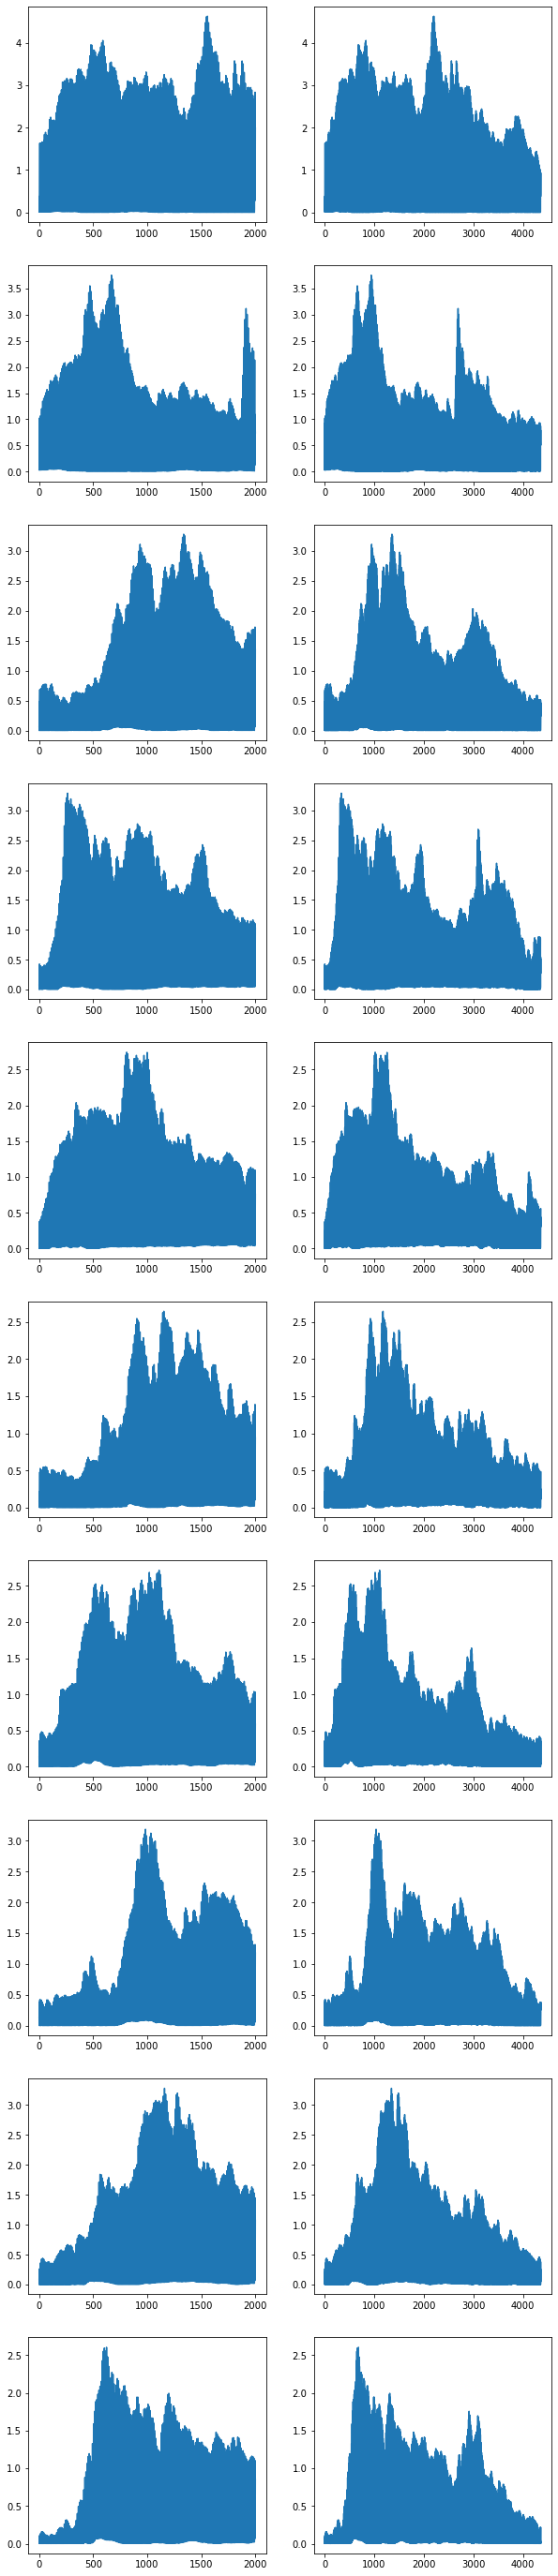

In [141]:
# Plot move repetition once with interpolation and once without
fig, axes = plt.subplots(nrows=10, ncols=2, figsize=(10,50))

for i in range(0,10):
    
#     r1 = list(range(0, len(move.loc[i].dropna())))[:-1]
    r1 = list(range(0, 2001))[:-1]
    axes[i,0].plot(r1, move.loc[i].drop("target").dropna()[0:2000])

    r2 = list(range(0, len(move_interpolated.loc[i])))[:-1]
    axes[i,1].plot(r2, move_interpolated.loc[i].drop("target"));



In [152]:
ex1_movements = list(range(1,13))
sub = load_data_DB1(subject=5, exercise=1)
df = pd.DataFrame()

for m in ex1_movements:
    df = df.append(get_full_repetitions(data=sub, movement=m), ignore_index=True)
    
df

,0,1,2,3,4,5,6,7,8,9,...,5920,5921,5922,5923,5924,5925,5926,5927,5928,5929
0,0.0024,0.2808,0.0073,0.0024,0.0049,0.0024,0.1660,0.2295,0.0854,0.2344,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.0024,0.2026,0.0049,0.0024,0.0049,0.0024,0.1587,0.2686,0.0317,0.2344,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.0024,0.2612,0.0269,0.0024,0.0024,0.0024,0.2637,0.3247,0.0220,0.1929,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0.0024,0.2271,0.0610,0.0024,0.0024,0.0024,0.1343,0.2832,0.0366,0.2100,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.0024,0.3320,0.0464,0.0024,0.0024,0.0024,0.1733,0.2686,0.0415,0.3027,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115,0.0024,0.0757,0.0024,0.0024,0.0024,0.0024,0.0854,0.2563,0.0342,0.2759,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
116,0.0049,0.0024,0.0391,0.1172,0.0049,0.0024,0.0806,0.2954,0.2368,0.2710,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
117,0.0049,0.4150,0.2393,0.3174,0.0146,0.0024,0.1050,0.3906,0.2686,0.4126,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
118,0.0024,0.4663,0.1245,0.3589,0.0122,0.0049,0.1050,0.2759,0.3101,0.4761,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [153]:
df_inter = interpolate_dataframe(df)
df_inter

,0,1,2,3,4,5,6,7,8,9,...,5921,5922,5923,5924,5925,5926,5927,5928,5929,target
0,0.0024,0.14160,0.2808,0.00730,0.0024,0.0049,0.0024,0.1660,0.22950,0.15745,...,0.00490,0.00365,0.00240,0.0024,0.01220,0.2637,0.3149,0.0513,0.1538,1
1,0.0024,0.10250,0.2026,0.00490,0.0024,0.0049,0.0024,0.1587,0.26860,0.15015,...,0.00240,0.00240,0.00240,0.0024,0.00240,0.2075,0.3149,0.0293,0.0928,1
2,0.0024,0.13180,0.2612,0.02690,0.0024,0.0024,0.0024,0.2637,0.32470,0.02200,...,0.16480,0.05370,0.00240,0.0024,0.00240,0.2002,0.3223,0.0244,0.1758,1
3,0.0024,0.11475,0.2271,0.06100,0.0024,0.0024,0.0024,0.1343,0.28320,0.03660,...,0.21970,0.01710,0.00240,0.0024,0.00240,0.1733,0.2759,0.0635,0.1978,1
4,0.0024,0.16720,0.3320,0.04640,0.0244,0.0024,0.0024,0.0024,0.08785,0.17330,...,0.00490,0.00240,0.00240,0.0024,0.22220,0.4321,0.2319,0.0317,0.2124,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115,0.0024,0.03905,0.0757,0.00240,0.0024,0.0024,0.0024,0.0024,0.08540,0.25630,...,0.00240,0.02930,0.00240,0.0024,0.02075,0.0391,0.1465,0.0464,0.1074,12
116,0.0049,0.00365,0.0024,0.03910,0.1172,0.0049,0.0024,0.0806,0.29540,0.23680,...,0.25880,0.31490,0.20260,0.0024,0.00240,0.0806,0.2441,0.1538,0.2881,12
117,0.0049,0.20995,0.4150,0.23930,0.3174,0.0146,0.0024,0.1050,0.24780,0.39060,...,0.15870,0.53960,0.29665,0.0537,0.01950,0.1318,0.1221,0.2954,0.0366,12
118,0.0024,0.23435,0.4663,0.29540,0.1245,0.2417,0.3589,0.0122,0.00855,0.00490,...,0.15385,0.08060,0.21120,0.3418,0.29540,0.3418,0.3882,0.3235,0.2588,12


In [154]:
X = df_inter.drop("target", axis=1)[0:2000]
y = df_inter["target"]


X_train, X_test, y_train, y_test = train_test_split(X, y,stratify=y, test_size=0.2)

clf = RandomForestClassifier()
clf.fit(X_train, y_train)
clf.score(X_test, y_test)

0.4166666666666667

In [151]:
y_test

80      9
59      6
45      5
81      9
35      4
108    11
91     10
16      2
111    12
44      5
14      2
100    11
39      4
62      7
5       1
55      6
117    12
2       1
94     10
66      7
22      3
76      8
75      8
26      3
Name: target, dtype: int64